In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 160)


In [25]:
file_path = r"D:/Forage/JP MORGAN/Nat_Gas.csv"  # <- your path

df = pd.read_csv(file_path)
df = df.rename(columns={"Dates": "date", "Prices": "price"})
df["date"] = pd.to_datetime(df["date"])  # auto-parse dates
df["price"] = pd.to_numeric(df["price"])
df = df.sort_values("date").reset_index(drop=True)

print(df.head()); print(df.tail()); print(df.shape)


        date  price
0 2020-10-31   10.1
1 2020-11-30   10.3
2 2020-12-31   11.0
3 2021-01-31   10.9
4 2021-02-28   10.9
         date  price
43 2024-05-31   11.4
44 2024-06-30   11.5
45 2024-07-31   11.6
46 2024-08-31   11.5
47 2024-09-30   11.8
(48, 2)


C:\Users\vaibh\AppData\Local\Temp\ipykernel_11244\4281939470.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"])  # auto-parse dates


In [26]:
origin = df["date"].min().normalize()
P = 365.25
t_days = (df["date"] - origin).dt.days.to_numpy(float)

X = np.column_stack([
    np.ones_like(t_days),          # intercept
    t_days / P,                    # linear trend
    (t_days / P) ** 2,             # quadratic trend
    np.sin(2*np.pi*t_days / P),    # annual sine
    np.cos(2*np.pi*t_days / P),    # annual cosine
    np.sin(4*np.pi*t_days / P),    # semi-annual sine
    np.cos(4*np.pi*t_days / P),    # semi-annual cosine
])

y = np.log(df["price"].to_numpy())
beta, *_ = np.linalg.lstsq(X, y, rcond=None)

def _features(t):
    t = np.asarray(t, dtype=float)
    return np.column_stack([
        np.ones_like(t),
        t / P,
        (t / P) ** 2,
        np.sin(2*np.pi*t / P),
        np.cos(2*np.pi*t / P),
        np.sin(4*np.pi*t / P),
        np.cos(4*np.pi*t / P),
    ])

def estimate_price(date_str: str) -> float:
    d = pd.to_datetime(date_str)
    td = (d - origin).days
    return float(np.exp(_features([td]) @ beta)[0])

print("Sanity check:", estimate_price("2025-03-15"))


Sanity check: 13.176142039745773


In [27]:
# 3.1 daily timeline
start = df["date"].min()
last  = df["date"].max()
all_days = pd.date_range(start, last + pd.Timedelta(days=365), freq="D")

t_all = (all_days - origin).days.to_numpy(float)
daily_pred = np.exp(_features(t_all) @ beta)
pred_df = pd.DataFrame({"date": all_days, "pred_price": daily_pred})

# 3.2 month-end aggregation
pred_df["month"] = pred_df["date"].dt.to_period("M")
monthly_pred = pred_df.groupby("month")["pred_price"].last().reset_index()
monthly_pred["date"] = monthly_pred["month"].dt.to_timestamp("M")

# 3.3 seasonality from history
df["month_num"] = df["date"].dt.month
seasonal = df.groupby("month_num")["price"].mean().reindex(range(1,13))

# 3.4 save CSVs
pred_df[["date","pred_price"]].to_csv("predictions_daily.csv", index=False)
monthly_pred[["date","pred_price"]].to_csv("predictions_monthly.csv", index=False)
print("Saved CSVs: predictions_daily.csv, predictions_monthly.csv")


Saved CSVs: predictions_daily.csv, predictions_monthly.csv


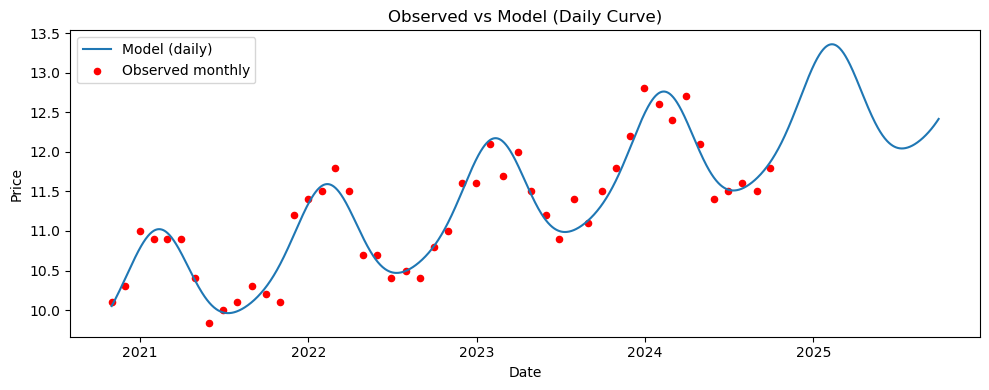

In [29]:
# Time series: observed vs model
plt.figure(figsize=(10,4))
plt.plot(pred_df["date"], pred_df["pred_price"], label="Model (daily)")
plt.scatter(df["date"], df["price"], s=20, color="red", label="Observed monthly")
plt.title("Observed vs Model (Daily Curve)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout()
plt.savefig("plot_timeseries.png"); plt.show()



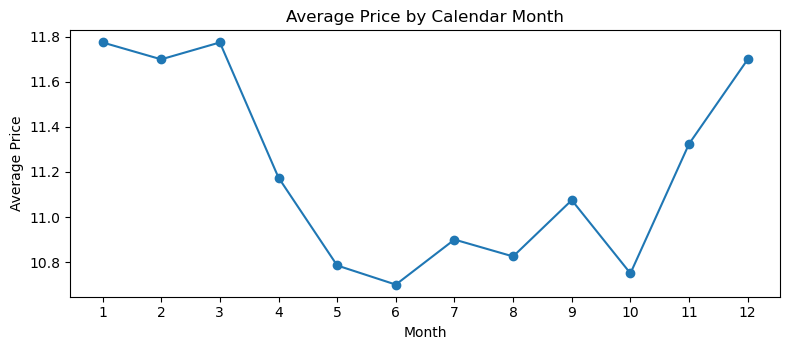

In [30]:
# Seasonality
plt.figure(figsize=(8,3.6))
plt.plot(seasonal.index, seasonal.values, marker="o")
plt.xticks(range(1,13))
plt.title("Average Price by Calendar Month")
plt.xlabel("Month"); plt.ylabel("Average Price"); plt.tight_layout()
plt.savefig("plot_seasonality.png"); plt.show()




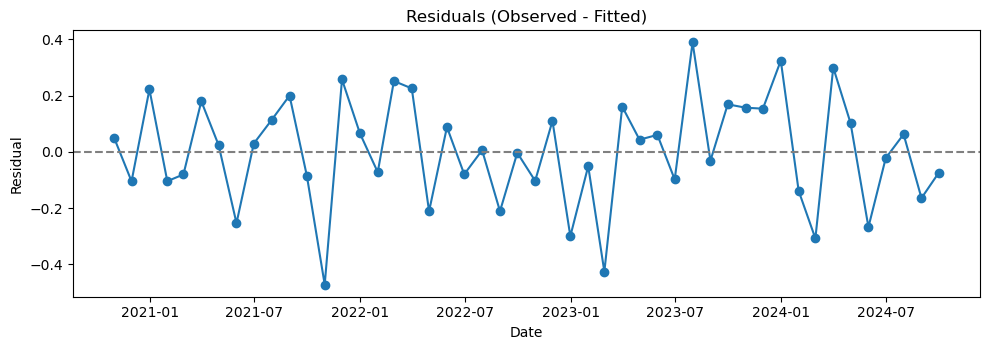

Saved PNGs: plot_timeseries.png, plot_seasonality.png, plot_residuals.png


In [31]:
# Residuals
fitted_monthly = np.exp(_features((df["date"]-origin).dt.days.to_numpy(float)) @ beta)
residuals = df["price"].to_numpy() - fitted_monthly
plt.figure(figsize=(10,3.6))
plt.plot(df["date"], residuals, marker="o")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Residuals (Observed - Fitted)")
plt.xlabel("Date"); plt.ylabel("Residual"); plt.tight_layout()
plt.savefig("plot_residuals.png"); plt.show()

print("Saved PNGs: plot_timeseries.png, plot_seasonality.png, plot_residuals.png")

In [32]:
print("Estimate on 2025-01-10:", estimate_price("2025-01-10"))


Estimate on 2025-01-10: 13.18651204267162
